In [30]:
### 
# DEPENDENCIES 
###
import itertools
import nltk
import re
import json
import pandas as pd
import numpy as np
from collections import Counter
# keras / tensorflow
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, Dense, Input, MaxPooling1D, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
# sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tree import Tree
# gensim
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
# plotting
from matplotlib import pyplot as plt
from matplotlib.widgets import CheckButtons
from wordcloud import WordCloud
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook  
# stanford corenlp
from stanfordcorenlp import StanfordCoreNLP
### 
# GLOBALS 
###
TRAINING_DATA_DIR="./datasets/BioASQ-trainingDataset6b.json"
TRAIN_SPLIT = 0.9
W2V_SIZE=50
W2V_SKIP_GRAM=1
### 
# FUNCTIONS 
###
def parse_questions_types(data):
    return zip(*[[json['body'], json['type']] for json in data['questions']])

def label_to_class(str_labels, label):
    return str_labels.index(label)

def json_to_df(json_file_path):
    with open(json_file_path, 'r') as f:
        return pd.DataFrame(json.load(f))
    
def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    filtered_tokens = []
    for word, pos in nltk.pos_tag(word_tokenize(text)):
        if len(word) < 2 and word != "?":
            continue
        filtered_tokens.append(word.lower())        
    return filtered_tokens

def build_vocab_idx(tokenized_q):
    vocab = dict()
    idx = 0
    for q in tokenized_q:
        for word in q:
            if word not in vocab:
                vocab[word] = idx
                idx += 1
    return vocab

def one_hot_encode(q_types):
    y = []
    list_classes = list(np.unique(q_types))
    for q_type in q_types:
        enc = np.zeros(len(list_classes))
        enc[list_classes.index(q_type)] = 1
        y.append(enc)
    return np.array(y)

In [28]:
[questions, q_types] = parse_questions_types(json_to_df(TRAINING_DATA_DIR))
tokenized_q = [tokenize(q) for q in questions]
vocab_idx = build_vocab_idx(tokenized_q)
vector_model = Word2Vec(tokenized_q, min_count=0, sg=W2V_SKIP_GRAM, size=W2V_SIZE)
max_nb_words = len(vector_model.wv.vocab)
max_seq_length = max([len(q) for q in tokenized_q])
sequences = [[vocab_idx[t] for t in q] for q in tokenized_q]
wv_matrix = (np.random.rand(max_nb_words, W2V_SIZE) - 0.5) / 5.0
for word, i in vocab_idx.items():
    wv_matrix[i] = vector_model.wv[word]

In [23]:
X = pad_sequences(sequences, maxlen=max_seq_length, padding="pre", truncating="post")
y = one_hot_encode(q_types)

(2026, 30)
(2026, 4)
(225, 30)
(225, 4)


Train on 2025 samples, validate on 226 samples
Epoch 1/30
2025/2025 [==============================] - 3s 1ms/step - loss: 0.8131 - val_loss: 0.7013
Epoch 2/30
2025/2025 [==============================] - 0s 209us/step - loss: 0.7480 - val_loss: 0.6239
Epoch 3/30
2025/2025 [==============================] - 0s 184us/step - loss: 0.7201 - val_loss: 0.6464
Epoch 4/30
2025/2025 [==============================] - 0s 182us/step - loss: 0.6994 - val_loss: 0.6442
Epoch 5/30
2025/2025 [==============================] - 0s 221us/step - loss: 0.6663 - val_loss: 0.6776
Epoch 6/30
2025/2025 [==============================] - 0s 221us/step - loss: 0.6544 - val_loss: 0.6053
Epoch 7/30
2025/2025 [==============================] - 0s 205us/step - loss: 0.6397 - val_loss: 0.5951
Epoch 8/30
2025/2025 [==============================] - 0s 185us/step - loss: 0.6246 - val_loss: 0.5648
Epoch 9/30
2025/2025 [==============================] - 0s 236us/step - loss: 0.6134 - val_loss: 0.5704
Epoch 10/30
2025/20

<IPython.core.display.Javascript object>


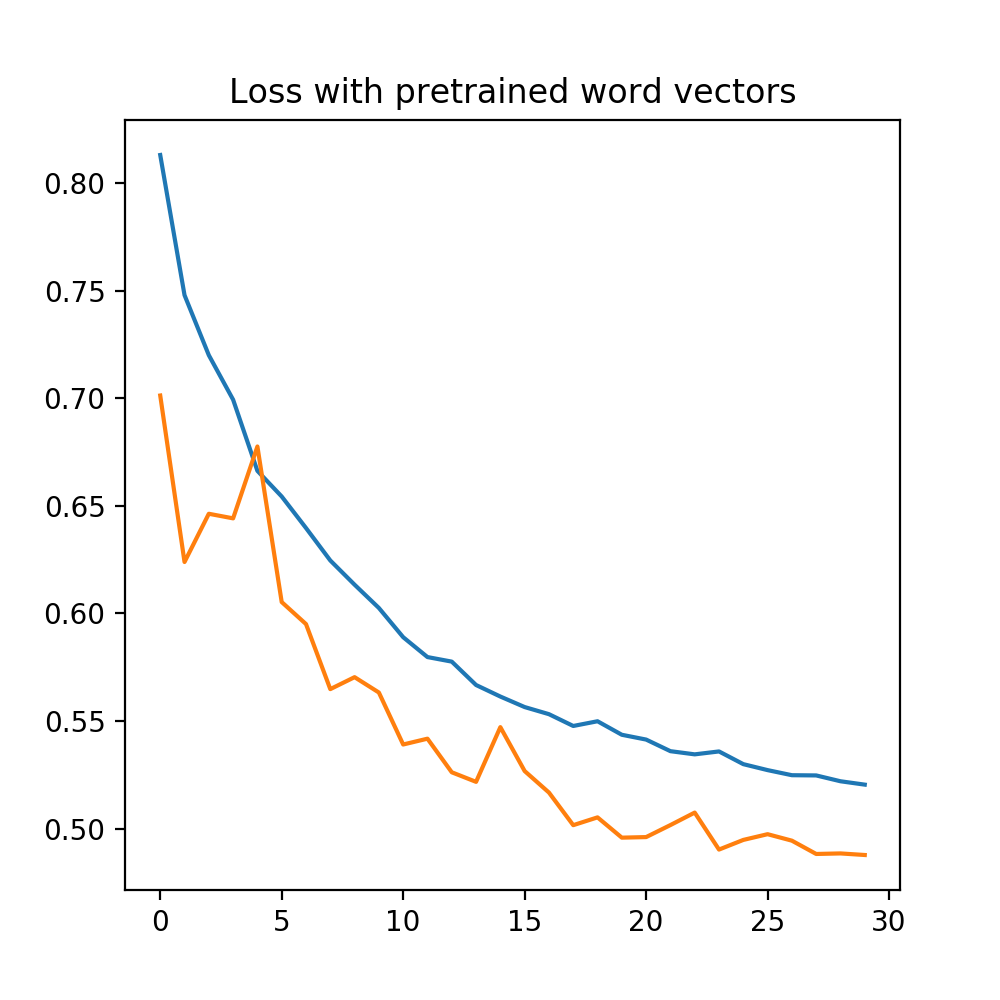

In [37]:
wv_layer = Embedding(max_nb_words,
                     W2V_SIZE,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=max_seq_length,
                     trainable=False)

# Inputs
comment_input = Input(shape=(max_seq_length,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(4, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])

hist = model.fit([data], y, validation_split=0.1, epochs=30, batch_size=256, shuffle=True)

history = pd.DataFrame(hist.history)
plt.figure(figsize=(5,5));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with pretrained word vectors");
plt.show();

In [ ]:
train_q_idx = round(len(tokenized_q)*TRAIN_SPLIT)
X_train, y_train = data[:train_q_idx], y[:train_q_idx]
X_test, y_test = data[train_q_idx:], y[train_q_idx:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)